In [1]:
!pip install keras-cv==0.4.0 -q
!pip install -U tensorflow -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.7 MB/s eta 0:00:00


In [2]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder, TextEncoderV2
from tensorflow import keras
from datasets import load_dataset

## Dataset

1. **matching**: identifying which captions correspond to unusual situation
2. **quality ranking**: identifying which captions are highly rated either by New Yorkers editors or crowd voting
3. **explanation**: generating explanations of highly rated captions

In [3]:
dataset = load_dataset("jmhessel/newyorker_caption_contest", "matching")
train, validation, test = dataset["train"], dataset["validation"], dataset["test"]

Generating train split:   0%|          | 0/9792 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/531 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/528 [00:00<?, ? examples/s]

Dataset newyorker_caption_contest downloaded and prepared to /root/.cache/huggingface/datasets/jmhessel___newyorker_caption_contest/matching/1.0.0/43749f7b7c0566b3b1bb518ee81866c0ae27f310ad1b3405918479d6eafcaabe. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=323x231 at 0x7FC9438A7490>,
 'contest_number': 49,
 'image_location': 'a bar',
 'image_description': 'Two priests and a rabbi are walking into a bar, as the bartender and another patron look on. The bartender talks on the phone while looking skeptically at the incoming crew.',
 'image_uncanny_description': 'The scene depicts a very stereotypical "bar joke" that would be unlikely to be encountered in real life; the skepticism of the bartender suggests that he is aware he is seeing this trope, and is explaining it to someone on the phone.',
 'entities': ['https://en.wikipedia.org/wiki/Rule_of_three_(writing)',
  'https://en.wikipedia.org/wiki/Bar_joke',
  'https://en.wikipedia.org/wiki/Religious_institute'],
 'questions': ['What is the bartender saying on the phone in response to the living, breathing, stereotypical bar joke that is unfolding?'],
 'caption_choices': ['Tell me about your childhood very quickly.',
  "Believe me

In [5]:
# image = train[0]["image"]

# RESOLUTION = 256

# def process_image(image_path, tokenized_text):
#     image = tf.io.read_file(image_path)
#     image = tf.io.decode_png(image, 3)
#     image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
#     return image, tokenized_text


# process_image("img.png", "hello, world!")

In [6]:
from PIL import Image

image = train[0]["image"]

RESOLUTION = 256

def process_image(image, tokenized_text):
    img = Image.new("RGB", image.size)
    img.paste(image)
    img = tf.keras.utils.img_to_array(img)
    img = tf.image.resize(img, (RESOLUTION, RESOLUTION))
    return img, tokenized_text

In [7]:
def process_entry(entry):
    image = entry["image"]
    caption = entry["caption_choices"][0] if entry['label'] == 'A' else entry['caption_choices'][0]
    return { "image": process_image(image, caption)[0], "caption": caption }

l = list(map(process_entry, test))


In [8]:
data_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/ai2-jack-public/caption_contest_data_public/all_contest_images.zip",
    extract=True,
)
data_path = os.path.splitext(data_path)[0]

columns_to_remove = [
    "image", 
    "image_uncanny_description", 
    "entities", 
    "questions", 
    "n_tokens_label", 
    "instance_id"
]

data_frame = pd.DataFrame(train.select(train.unique("contest_number")).remove_columns(columns_to_remove))
data_frame["image_path"] = data_frame["contest_number"].apply(lambda x: os.path.join(data_path, str(x) + ".jpeg"))
data_frame["caption"] = data_frame["image_description"]
data_frame

39523209/39523209 [==============================] - 0s 0us/step


contest_number         image_location  \
0               742         an art gallery   
1               115                  a bar   
2               474              an office   
3               627  a ledge of a building   
4               528         an office room   
..              ...                    ...   
417             148                 museum   
418             582                   road   
419             656   a therapist's office   
420             203   the castle outskirts   
421             668               a castle   

                                     image_description  \
0    A group of people are standing in an art museu...   
1    A man in a hazmat suit is having a drink with ...   
2    Two businessmen are passing a colleague. He ha...   
3    There are two people looking at a menu on a ba...   
4    A business meeting is going on. The boss is at...   
..                                                 ...   
417  A woman looks at a lineup on criminals in a po...   
418  Two people are riding a two person bike down t...   
419  A man in a sombrero  is holding a guitar while...   
420  Men have captured a giant. The giant is in a w...   
421  There is a maiden in a castle. A dragon is out...   

                                       caption_choices  \
0    [I'm surprised you can ghostwrite for him. I'v...   
1    [Well the catcher is wearing a mask but everyo...   
2    [This suit looked way better in the store., I ...   
3    [The board just voted to remove the net., Bob ...   
4    [Maybe His Highness should make reservations n...   
..                                                 ...   
417  [By the way, we are not allowed to show the fa...   
418  [You can't imagine what it's like to have some...   
419  [If I had more dough, I'd be in first class., ...   
420  [Throw us a doughnut!, We discovered the Inter...   
421  [You’ll love the headlight exhibit in the next...   

                                      from_description label  \
0    scene: an art gallery description: A group of ...     C   
1    scene: a bar description: A man in a hazmat su...     D   
2    scene: an office description: Two businessmen ...     D   
3    scene: a ledge of a building description: Ther...     C   
4    scene: an office room description: A business ...     E   
..                                                 ...   ...   
417  scene: museum description: A woman looks at a ...     A   
418  scene: road description: Two people are riding...     E   
419  scene: a therapist's office description: A man...     B   
420  scene: the castle outskirts description: Men h...     B   
421  scene: a castle description: There is a maiden...     B   

                                            image_path  \
0    /root/.keras/datasets/all_contest_images/742.jpeg   
1    /root/.keras/datasets/all_contest_images/115.jpeg   
2    /root/.keras/datasets/all_contest_images/474.jpeg   
3    /root/.keras/datasets/all_contest_images/627.jpeg   
4    /root/.keras/datasets/all_contest_images/528.jpeg   
..                                                 ...   
417  /root/.keras/datasets/all_contest_images/148.jpeg   
418  /root/.keras/datasets/all_contest_images/582.jpeg   
419  /root/.keras/datasets/all_contest_images/656.jpeg   
420  /root/.keras/datasets/all_contest_images/203.jpeg   
421  /root/.keras/datasets/all_contest_images/668.jpeg   

                                               caption  
0    A group of people are standing in an art museu...  
1    A man in a hazmat suit is having a drink with ...  
2    Two businessmen are passing a colleague. He ha...  
3    There are two people looking at a menu on a ba...  
4    A business meeting is going on. The boss is at...  
..                                                 ...  
417  A woman looks at a lineup on criminals in a po...  
418  Two people are riding a two person bike down t...  
419  A man in a sombrero  is holding a guitar while...  
420  Men have captured

In [9]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)

# Drop rows whose caption length is greater than MAX_PROMPT_LENGTH
data_frame = data_frame[data_frame["caption"].apply(lambda x: len(process_text(x)) <= MAX_PROMPT_LENGTH)]

# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))


all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)


1356917/1356917 [==============================] - 0s 0us/step


In [10]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


492466864/492466864 [==============================] - 3s 0us/step


In [11]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)


images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


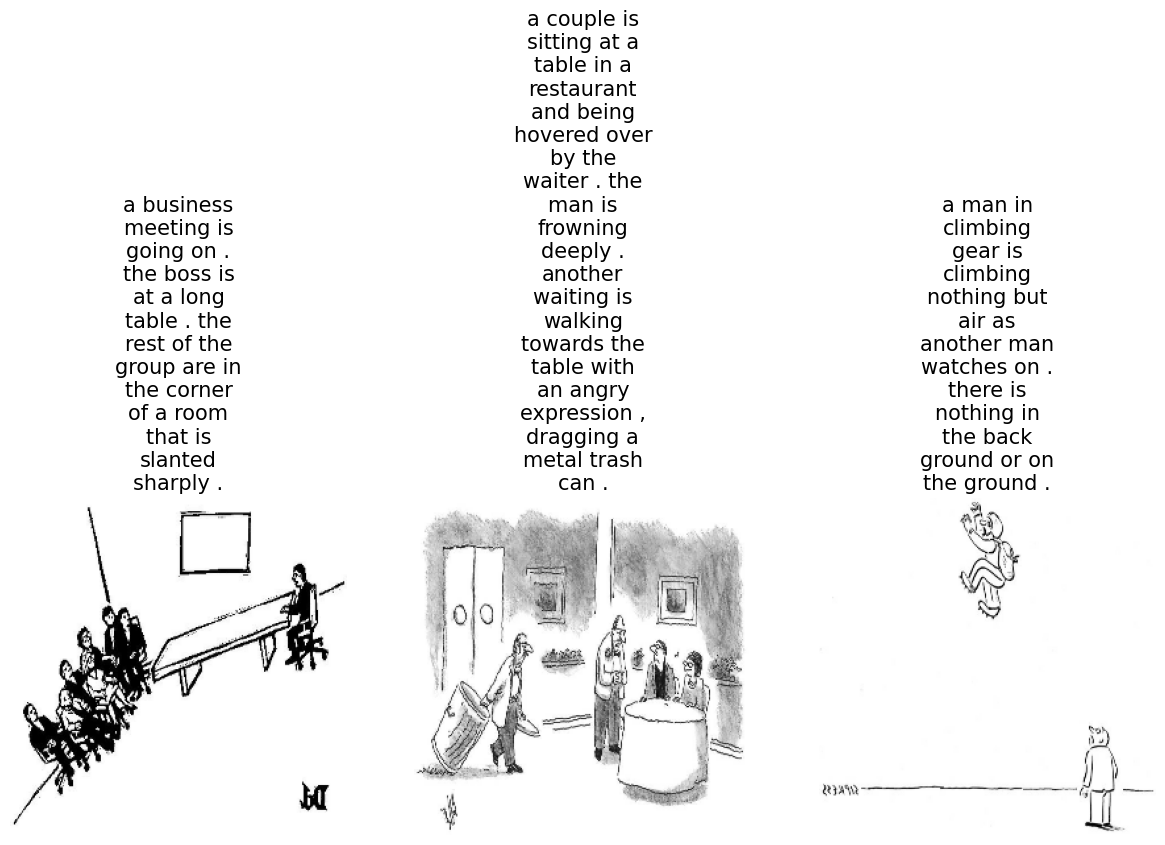

In [12]:
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

In [13]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


In [14]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")


3439090152/3439090152 [==============================] - 22s 0us/step


In [15]:
epochs = 80
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/80


Instructions for updating:
Use fn_output_signature instead


105/105 [==============================] - 326s 447ms/step - loss: 0.1135
Epoch 2/80
105/105 [==============================] - 50s 461ms/step - loss: 0.1030
Epoch 3/80
105/105 [==============================] - 51s 470ms/step - loss: 0.1028
Epoch 4/80
105/105 [==============================] - 51s 462ms/step - loss: 0.1167
Epoch 5/80
105/105 [==============================] - 51s 467ms/step - loss: 0.1014
Epoch 6/80
105/105 [==============================] - 51s 466ms/step - loss: 0.1166
Epoch 7/80
105/105 [==============================] - 51s 467ms/step - loss: 0.1132
Epoch 8/80
105/105 [==============================] - 53s 490ms/step - loss: 0.1221
Epoch 9/80
105/105 [==============================] - 51s 465ms/step - loss: 0.1194
Epoch 10/80
105/105 [==============================] - 51s 464ms/step - loss: 0.1111
Epoch 11/80
105/105 [==============================] - 51s 470ms/step - loss: 0.1145
Epoch 12/80
105/105 [==============================] - 52s 472ms/step - loss: 0.1069

In [18]:
weights_path = "finetuned_stable_diffusion.h5"

img_height = img_width = 512
model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
# We just reload the weights of the fine-tuned diffusion model.
model.diffusion_model.load_weights(weights_path)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
model.diffusion_model.save("/content/drive/My Drive/finetuned_stable_diffusion.h5")

In [32]:
prompts = [test[0]["image_description"], test[1]["image_description"], test[4]["image_description"]]
images_to_generate = 2
outputs = {}

for prompt in prompts:
    generated_images = model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})


25/25 [==============================] - 6s 247ms/step


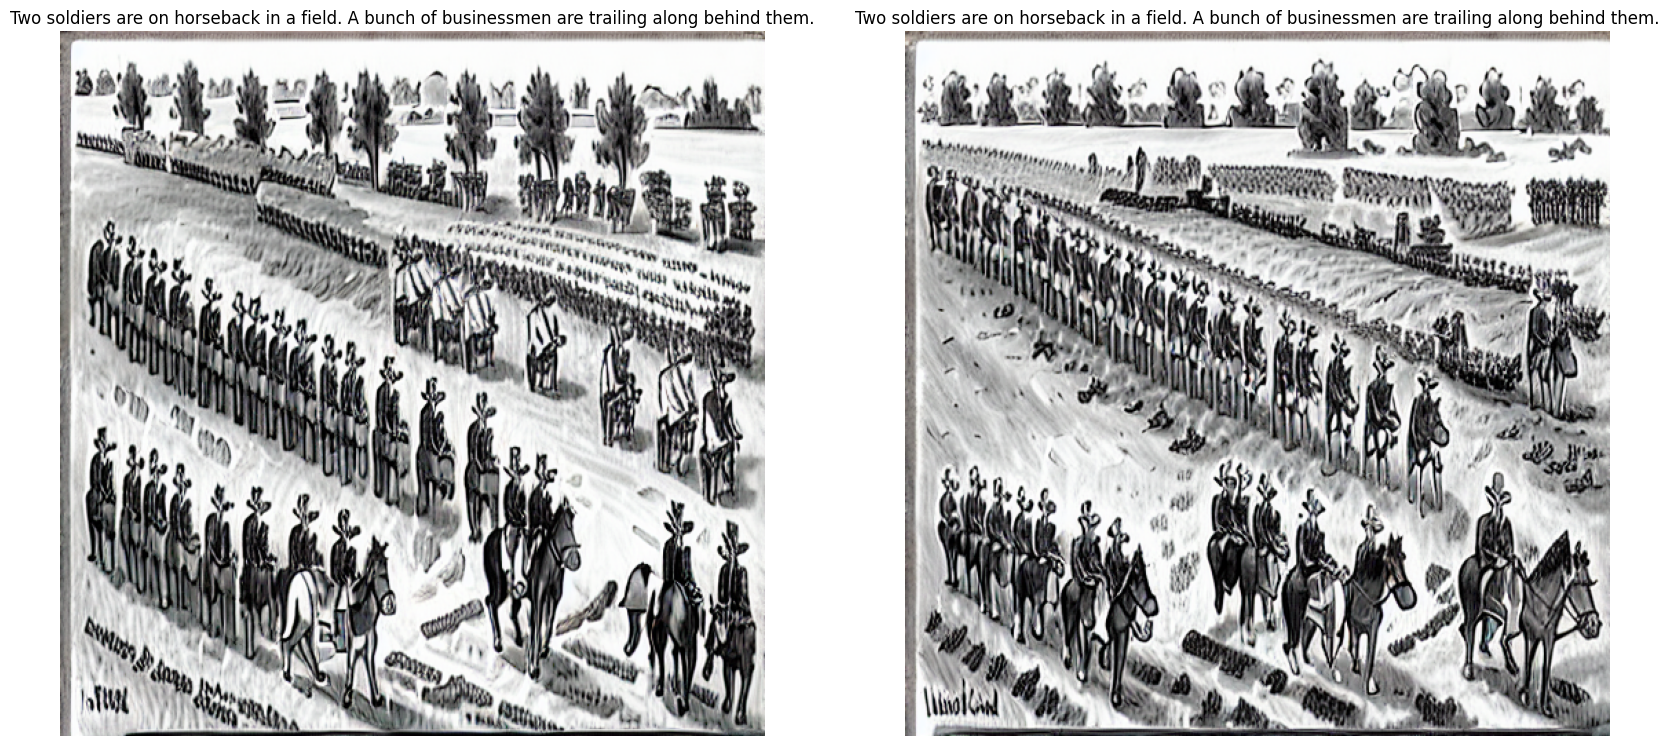

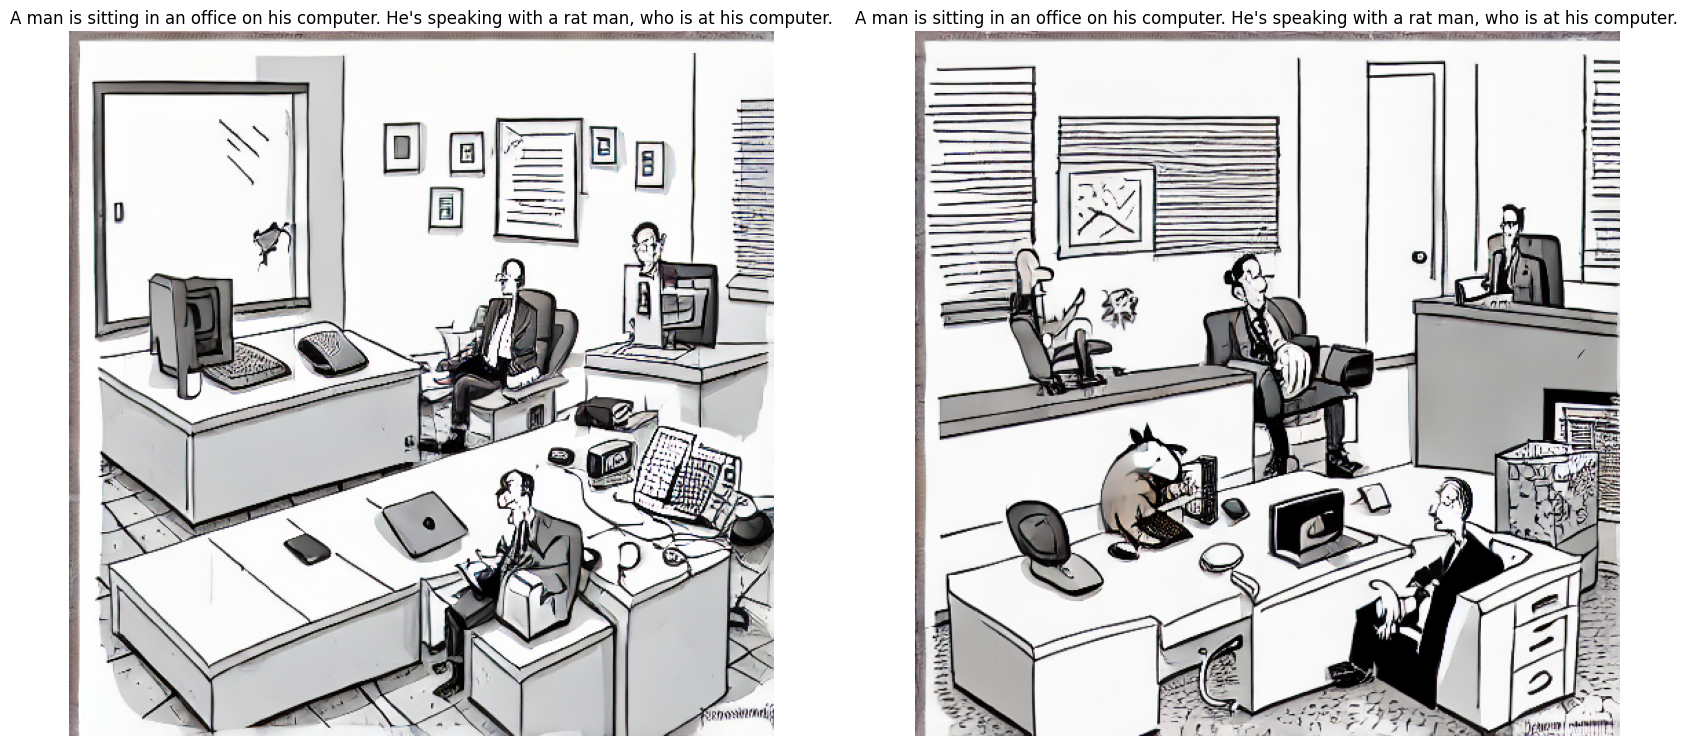

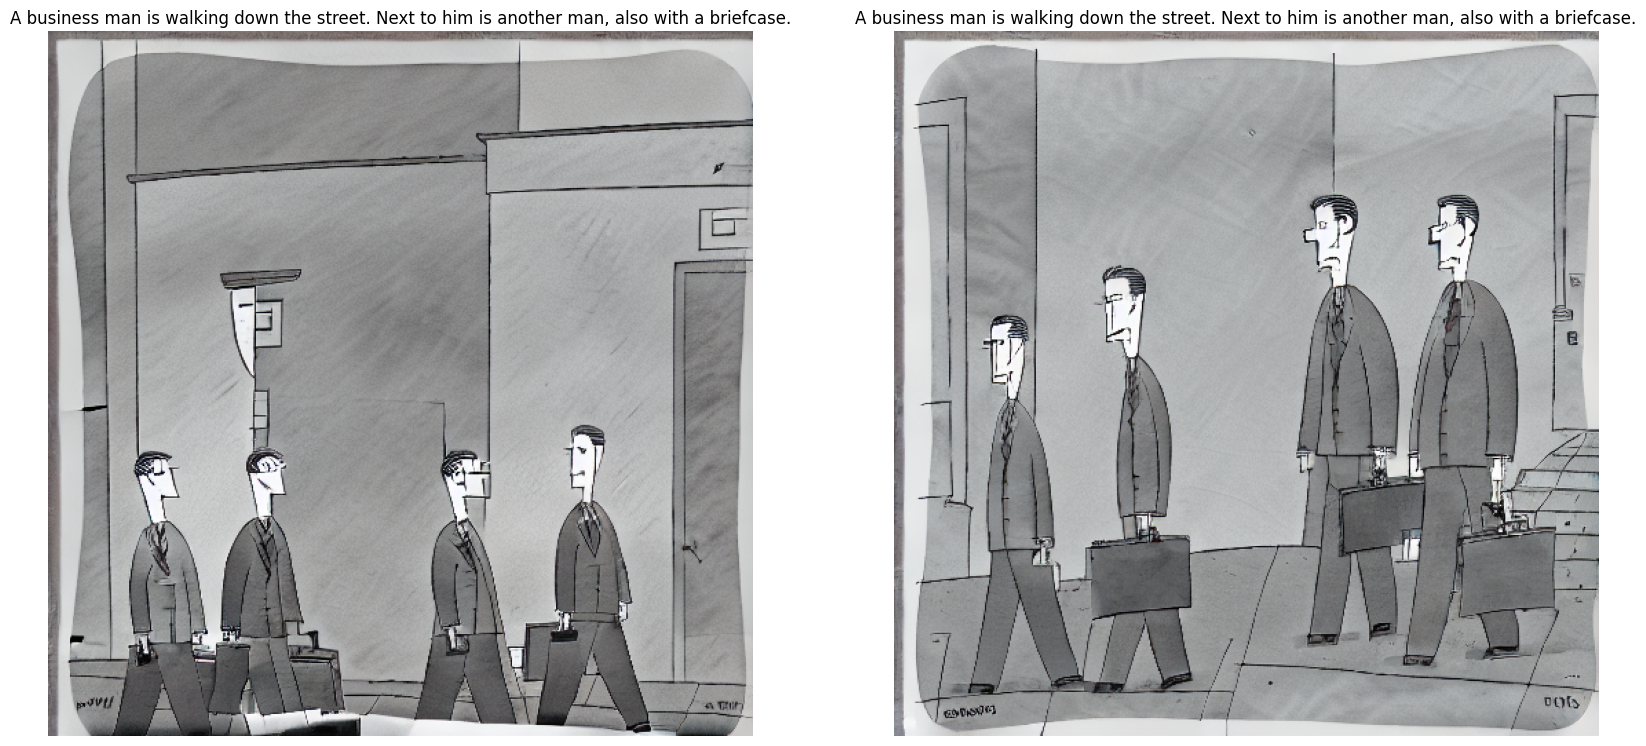

In [33]:
def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)


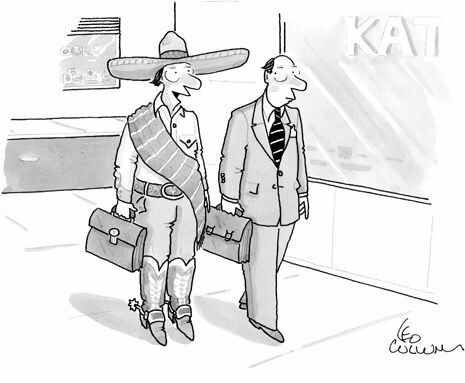

In [36]:
test_images = [test[0]["image"], test[1]["image"], test[4]["image"]]

test_images[2]